In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating Embeddings of items in FasionMNIST with an autoencoder
![](https://www.compthree.com/images/blog/ae/ae.png)

In [73]:
import torch
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from model import AutoEncoder

In [74]:
# reproducibility
torch.manual_seed(5);

#### Config

In [133]:
BATCH_SIZE = 64
DEVICE = (torch.device("cuda") if torch.cuda.is_available() 
          else (torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")))

ENCODER_PARAMS = [28 * 28, 256, 3]
DECODER_PARAMS = [3, 256, 28 * 28]

#### Load FashionMNIST

In [76]:
train_set = FashionMNIST(
    root="./data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_set = FashionMNIST(
    root="./data",
    train=False,
    download=False,
    transform=ToTensor()
)

#### Split train into train and validation
80/20 split

In [77]:
split = [0.8, 0.2]
train_set, val_set = random_split(train_set, split)

In [78]:
len(train_set), len(val_set), len(test_set)

(48000, 12000, 10000)

#### Visualize Data

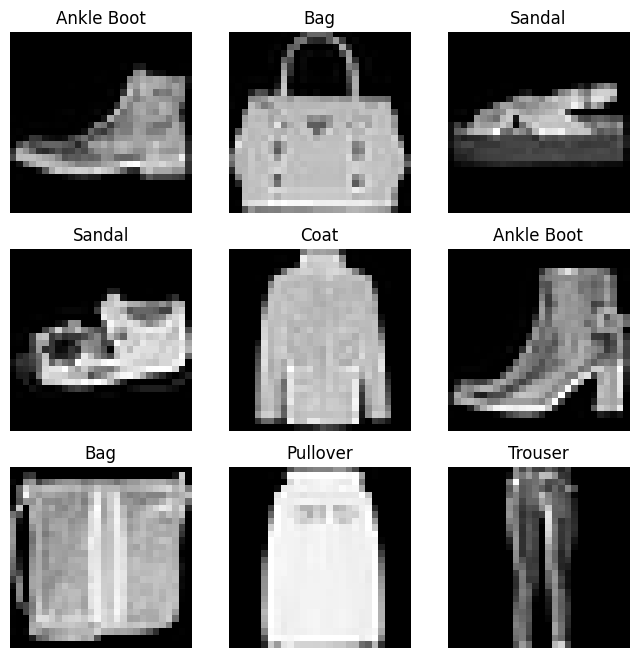

In [79]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Create dataloaders

In [80]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

#### Create autoencoder

In [185]:
autoencoder = AutoEncoder(encoder_params=[28 * 28, 256, 3], decoder_params=[3, 256, 28 * 28])

In [186]:
autoencoder

AutoEncoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Linear(in_features=256, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): ReLU()
      )
      (1): Linear(in_features=256, out_features=784, bias=True)
    )
  )
)

#### Set up training

In [187]:
LR = 3e-4

In [188]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

#### Overfit on 1 item

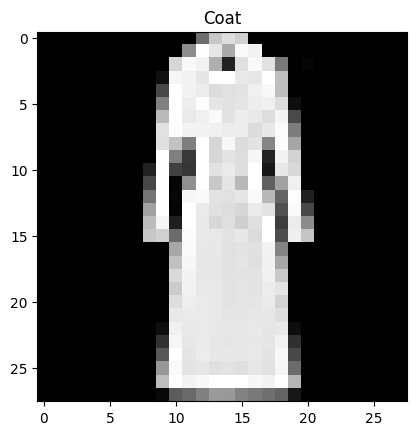

In [189]:
mini_batch = train_set[0]

plt.title(labels_map[mini_batch[1]])
plt.imshow(mini_batch[0][0], cmap="gray");

In [190]:
X = mini_batch[0].unsqueeze(0)
Y = torch.tensor([mini_batch[1]])

batch = (X, Y)

In [191]:
def train_batch(batch, model, criterion, optimizer, device):
    model.train()
    
    X, Y = batch
    X = X.to(device)
    X = X.view(-1, 28*28)

    # reconstructed X
    X_hat = model(X)
    
    loss = criterion(X_hat, X)
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [192]:
autoencoder = autoencoder.to(DEVICE)
epochs = 50

In [193]:
for i in range(epochs):
    loss = train_batch(batch, autoencoder, criterion, optimizer, DEVICE)
    print(f"[Epoch {i + 1}]: Loss={loss.item()}")

[Epoch 1]: Loss=0.26690080761909485
[Epoch 2]: Loss=0.2577551305294037
[Epoch 3]: Loss=0.25034379959106445
[Epoch 4]: Loss=0.2425718903541565
[Epoch 5]: Loss=0.23441259562969208
[Epoch 6]: Loss=0.22630691528320312
[Epoch 7]: Loss=0.21814657747745514
[Epoch 8]: Loss=0.2095879465341568
[Epoch 9]: Loss=0.20051848888397217
[Epoch 10]: Loss=0.19095906615257263
[Epoch 11]: Loss=0.18091964721679688
[Epoch 12]: Loss=0.17037136852741241
[Epoch 13]: Loss=0.15946237742900848
[Epoch 14]: Loss=0.148221954703331
[Epoch 15]: Loss=0.136682391166687
[Epoch 16]: Loss=0.1251809298992157
[Epoch 17]: Loss=0.11383801698684692
[Epoch 18]: Loss=0.10277707129716873
[Epoch 19]: Loss=0.09216375648975372
[Epoch 20]: Loss=0.08211394399404526
[Epoch 21]: Loss=0.07284993678331375
[Epoch 22]: Loss=0.06434988975524902
[Epoch 23]: Loss=0.05665436387062073
[Epoch 24]: Loss=0.04981335252523422
[Epoch 25]: Loss=0.04380049929022789
[Epoch 26]: Loss=0.03850491717457771
[Epoch 27]: Loss=0.033804863691329956
[Epoch 28]: Loss=

##### Embedding

In [194]:
autoencoder.eval()

ground_truth = X.view(-1, 28*28).to(DEVICE)
embedding = autoencoder.encoder(ground_truth)[0]
embedding.detach()

tensor([ 0.7798, -2.2690, -0.6431], device='mps:0')

##### Compare x to $\hat{x}$

In [195]:
X_hat = autoencoder(ground_truth)

X = ground_truth[0].view(28, 28).cpu().detach()
X_hat = X_hat[0].view(28, 28).cpu().detach()

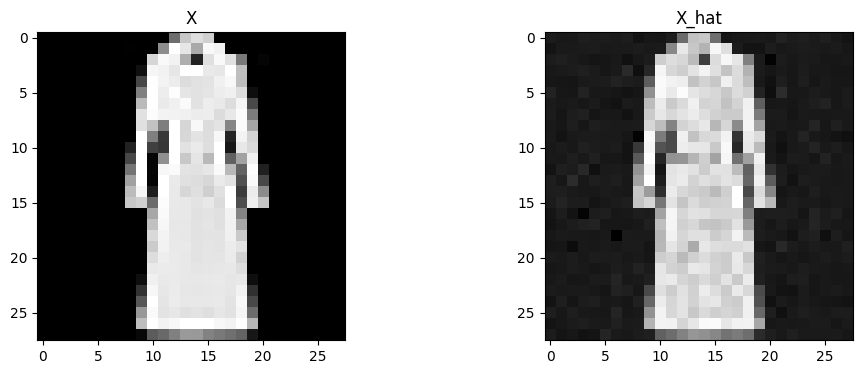

In [196]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title("X")
ax2.set_title("X_hat")

ax1.imshow(X, cmap="gray")
ax2.imshow(X_hat, cmap="gray")